In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("whitegrid")

/Users/chengchengfu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/chengchengfu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def load_and_clean_csv(filename, start_string):
    try:
        header_row = 0
        with open(filename, 'r') as f:
            for i, line in enumerate(f):
                if line.startswith(f'"{start_string}"'):
                    header_row = i
                    break
        if header_row == 0 and start_string == "Carrier Code":
             with open(filename, 'r') as f:
                for i, line in enumerate(f):
                    if line.startswith(f'{start_string}'):
                        header_row = i
                        break
        df = pd.read_csv(filename, skiprows=header_row, quotechar='"')
        df.columns = df.columns.str.strip().str.replace(r'[\s\(\)]+', '_', regex=True)
        df = df.dropna(axis=1, how='all')
        return df
    except Exception as e:
        return None

In [3]:
# --- 1. Load and Clean Data ---
df_dep_raw = load_and_clean_csv('data/departures.csv', 'Carrier Code')
df_arr_raw = load_and_clean_csv('data/arrivals.csv', 'Carrier Code')

# Clean Departures
df_dep_raw = df_dep_raw.rename(columns={'Date_MM/DD/YYYY_': 'date', 'Departure_delay_Minutes_': 'dep_delay'})
df_dep_raw['Tail_Number'] = df_dep_raw['Tail_Number'].str.strip()
df_dep_raw['date'] = pd.to_datetime(df_dep_raw['date'], format='%m/%d/%Y')
df_dep_raw['actual_dep_datetime'] = pd.to_datetime(df_dep_raw['date'].astype(str) + ' ' + df_dep_raw['Actual_departure_time'], format='%Y-%m-%d %H:%M', errors='coerce')
df_dep_raw['sched_dep_datetime'] = pd.to_datetime(df_dep_raw['date'].astype(str) + ' ' + df_dep_raw['Scheduled_departure_time'], format='%Y-%m-%d %H:%M', errors='coerce')
mask_dep = (df_dep_raw['actual_dep_datetime'] < (df_dep_raw['sched_dep_datetime'] - pd.Timedelta(hours=12)))
df_dep_raw.loc[mask_dep, 'actual_dep_datetime'] += pd.Timedelta(days=1)
df_dep_raw['type'] = 'departure'
df_dep_clean = df_dep_raw.dropna(subset=['actual_dep_datetime', 'Tail_Number']).add_prefix('dep_')

# Clean Arrivals
df_arr_raw = df_arr_raw.rename(columns={'Date_MM/DD/YYYY_': 'date', 'Arrival_Delay_Minutes_': 'arr_delay', 'Delay_Weather_Minutes_': 'weather_delay'})
df_arr_raw['Tail_Number'] = df_arr_raw['Tail_Number'].str.strip()
df_arr_raw['date'] = pd.to_datetime(df_arr_raw['date'], format='%m/%d/%Y')
df_arr_raw['actual_arr_datetime'] = pd.to_datetime(df_arr_raw['date'].astype(str) + ' ' + df_arr_raw['Actual_Arrival_Time'], format='%Y-%m-%d %H:%M', errors='coerce')
df_arr_raw['sched_arr_datetime'] = pd.to_datetime(df_arr_raw['date'].astype(str) + ' ' + df_arr_raw['Scheduled_Arrival_Time'], format='%Y-%m-%d %H:%M', errors='coerce')
mask_arr = (df_arr_raw['actual_arr_datetime'] < (df_arr_raw['sched_arr_datetime'] - pd.Timedelta(hours=12)))
df_arr_raw.loc[mask_arr, 'actual_arr_datetime'] += pd.Timedelta(days=1)
df_arr_raw['type'] = 'arrival'
df_arr_clean = df_arr_raw.dropna(subset=['actual_arr_datetime', 'Tail_Number']).add_prefix('arr_')

# Merge
df_dep_clean = df_dep_clean.rename(columns={'dep_Tail_Number': 'Tail_Number', 'dep_actual_dep_datetime': 'datetime'})
df_arr_clean = df_arr_clean.rename(columns={'arr_Tail_Number': 'Tail_Number', 'arr_actual_arr_datetime': 'datetime'})
df_events = pd.concat([df_arr_clean, df_dep_clean]).sort_values(by=['Tail_Number', 'datetime'])

turnaround_data = []
for tail_num, group in df_events.groupby('Tail_Number'):
    group['prev_type'] = group['arr_type'].shift(1)
    group['prev_arr_delay'] = group['arr_arr_delay'].shift(1)
    group['prev_weather_delay'] = group['arr_weather_delay'].shift(1)
    turnaround_data.append(group[(group['dep_type'] == 'departure') & (group['prev_type'] == 'arrival')])

df_merged = pd.concat(turnaround_data)
df_merged = df_merged.rename(columns={
    'prev_arr_delay': 'inbound_flight_arr_delay', 
    'prev_weather_delay': 'inbound_weather_delay',
    'dep_date': 'date', 
    'dep_dep_delay': 'dep_delay'
})
df_merged['inbound_flight_arr_delay'] = df_merged['inbound_flight_arr_delay'].fillna(0)
df_merged['inbound_weather_delay'] = df_merged['inbound_weather_delay'].fillna(0)

In [4]:
# --- 2. Aggregate to Daily Level ---
daily_ts = df_merged.set_index('date').resample('D').agg({
    'dep_delay': 'mean',
    'inbound_flight_arr_delay': 'mean',
    'inbound_weather_delay': 'mean'
}).dropna()


print("Daily Time Series created. Rows:", len(daily_ts))



# --- 3. Temporal Split ---
split_date = '2023-11-01'
train_ts = daily_ts[daily_ts.index < split_date]
test_ts = daily_ts[daily_ts.index >= split_date]

Daily Time Series created. Rows: 365


In [5]:
# --- 4. Model 1: ARIMA (Univariate Baseline) ---
# Only uses past departure delays to predict future departure delays
print("\n--- Training ARIMA (Baseline) ---")
# order=(p,d,q) -> (5,1,0) is a standard weekly pattern guess
arima_model = ARIMA(train_ts['dep_delay'], order=(5,1,0)) 
arima_fit = arima_model.fit()
forecast_arima = arima_fit.forecast(steps=len(test_ts))
forecast_arima.index = test_ts.index

# --- 5. Model 2: SARIMAX (Multivariate with Exogenous Variable) ---

print("\n--- Training SARIMAX (With Inbound Delay) ---")

exog_cols = ['inbound_flight_arr_delay', 'inbound_weather_delay']
sarimax_model = SARIMAX(train_ts['dep_delay'], exog=train_ts[exog_cols], order=(5,1,0))
sarimax_fit = sarimax_model.fit(disp=False)
forecast_sarimax = sarimax_fit.forecast(steps=len(test_ts), exog=test_ts[exog_cols])
forecast_sarimax.index = test_ts.index


--- Training ARIMA (Baseline) ---

--- Training SARIMAX (With Inbound Delay) ---



--- Evaluation ---
--- ARIMA (Baseline) Metrics ---
MAE: 10.66
RMSE: 14.26
--- SARIMAX (With Inbound) Metrics ---
MAE: 7.45
RMSE: 9.28


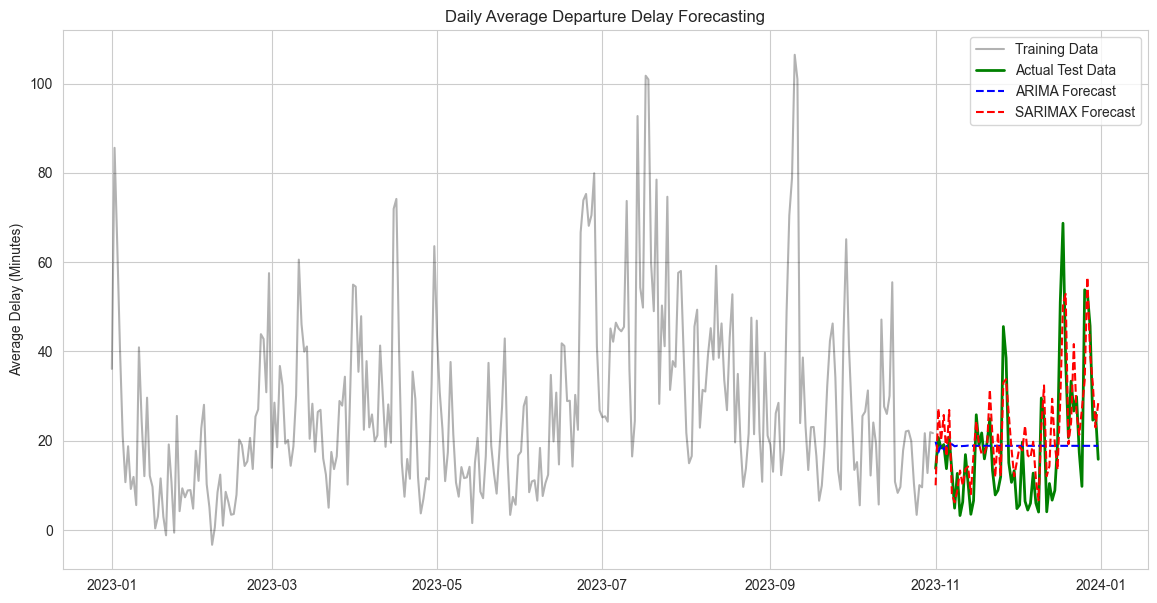

In [6]:
# --- 6. Evaluation ---
def evaluate_forecast(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {name} Metrics ---")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

print("\n--- Evaluation ---")
evaluate_forecast(test_ts['dep_delay'], forecast_arima, "ARIMA (Baseline)")
evaluate_forecast(test_ts['dep_delay'], forecast_sarimax, "SARIMAX (With Inbound)")

plt.figure(figsize=(14, 7))
plt.plot(train_ts.index, train_ts['dep_delay'], label='Training Data', color='black', alpha=0.3)
plt.plot(test_ts.index, test_ts['dep_delay'], label='Actual Test Data', color='green', linewidth=2)
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='blue', linestyle='--')
plt.plot(forecast_sarimax.index, forecast_sarimax, label='SARIMAX Forecast', color='red', linestyle='--')
plt.title('Daily Average Departure Delay Forecasting')
plt.ylabel('Average Delay (Minutes)')
plt.legend()
#plt.savefig('ts_forecast_comparison.png')
plt.show()

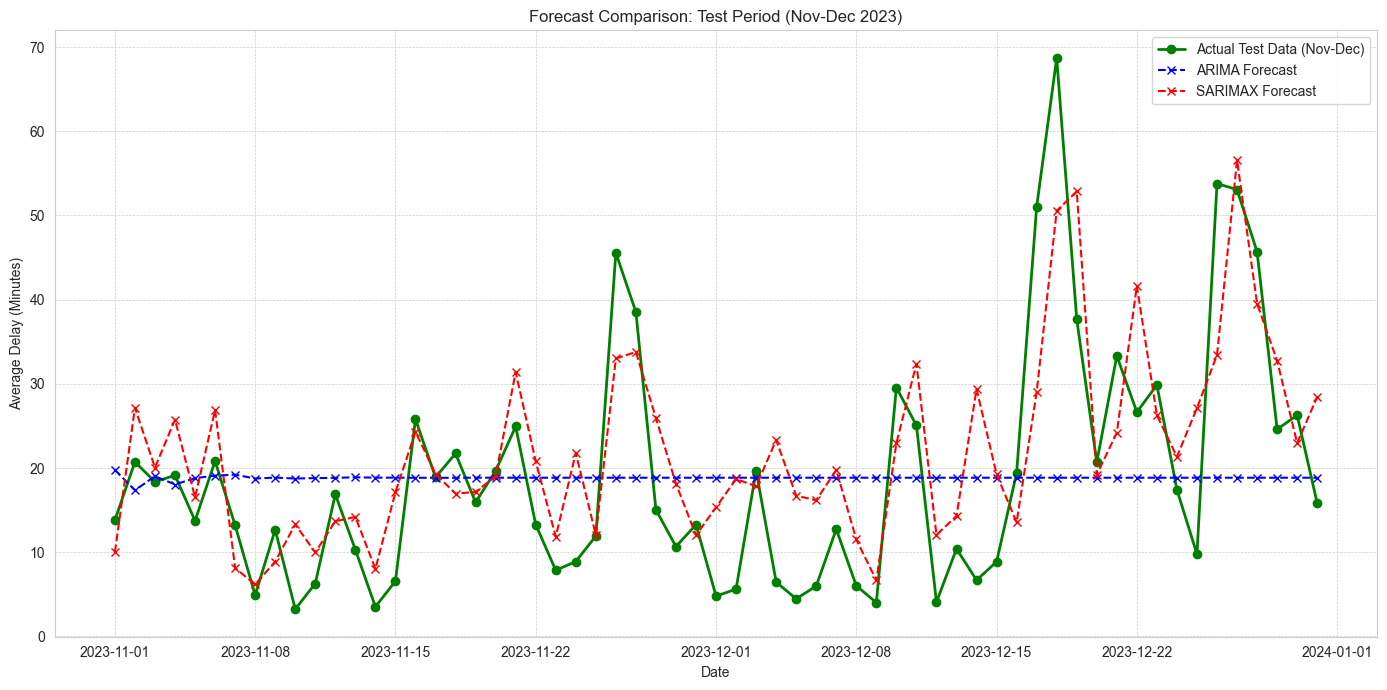

In [7]:
plt.figure(figsize=(14, 7))
# Only plot the test data and forecasts
plt.plot(test_ts.index, test_ts['dep_delay'], label='Actual Test Data (Nov-Dec)', color='green', linewidth=2, marker='o')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='blue', linestyle='--', marker='x')
plt.plot(forecast_sarimax.index, forecast_sarimax, label='SARIMAX Forecast', color='red', linestyle='--', marker='x')

plt.title('Forecast Comparison: Test Period (Nov-Dec 2023)')
plt.ylabel('Average Delay (Minutes)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig('ts_forecast_zoomed.png')
plt.show()